# Analysing my Spotify streaming history

This is a small, fun project I wanted to do: the first part will be about analysing my listening history and the second about the genres I listen to.

# Loading the data

The first part, is downloading the Spotify streaming history. You can get it by using the [download my data](https://support.spotify.com/us/article/understanding-my-data/) function from Spotify. They will email you the link to download the data a few days later. Inside the folder you'll find multiple "StreamingHistory.json" files which contains the data we need. It has the following scheme:

In [1]:
{
    "endTime" : "2021-04-27 19:34",
    "artistName" : "grandson",
    "trackName" : "Identity",
    "msPlayed" : 216000
}

{'artistName': 'grandson',
 'endTime': '2021-04-27 19:34',
 'msPlayed': 216000,
 'trackName': 'Identity'}

Databases have all the functions we need for data exploration, so we will load the data into a database. We'll use the sqlite module, here is the code to download it.

In [2]:
pip install mysql-connector-python

     |████████████████████████████████| 30.9 MB 80 kB/s 


Let's create and connect to the database, which will store the data into the 'spotify.db' file.

In [3]:
import sqlite3

database = sqlite3.connect('spotify.db')

Let's create a table for our streaming history which follows the json scheme. We add a unique id as primary key.

In [ ]:
#create
database.execute("""CREATE TABLE IF NOT EXISTS streaming_history(
                    endTime DATETIME,
                    artistName varchar(40),
                    trackName varchar(40),
                    msPlayed int,
                    id INTEGER PRIMARY KEY AUTOINCREMENT);""")
database.commit()

Now let's insert our streaming history JSON into the database. You must include the file path and the number of files.

In [ ]:
import json

def getData(path, n):
  data = []
  for i in range(n):
    p = path + str(i) + ".json"
    with open(p, 'r') as file:
      data.extend(json.loads(file.read()))
  return data

data = getData("/content/StreamingHistory", 5)
print("Added " + str(len(data)) + " music streams")

Added 48147 music streams


In [ ]:
keys = ["endTime", "artistName", "trackName", "msPlayed"]

for item in data:
    values = [item.get(key, None) for key in keys]
    cmd = """INSERT INTO streaming_history VALUES(?, ?, ?, ?, null);"""
    database.execute(cmd, values)

database.commit()

Check if it worked

In [ ]:
cmd = """ SELECT * FROM streaming_history LIMIT 10;"""
cur = database.execute(cmd)
res = cur.fetchall()

for r in res:
  print(r)

('2020-06-24 07:45', 'Foo Fighters', 'These Days', 294417, 1)
('2020-06-25 00:02', 'NF', 'One Hundred', 192800, 2)
('2020-06-25 00:06', 'NF', 'Outro', 212186, 3)
('2020-06-25 00:09', 'NF', 'Intro 2', 195933, 4)
('2020-06-25 00:14', 'NF', 'Therapy Session', 331480, 5)
('2020-06-25 00:18', 'NF', 'I Just Wanna Know', 226306, 6)
('2020-06-25 00:24', 'NF', 'How Could You Leave Us', 322586, 7)
('2020-06-25 00:28', 'NF', 'Breathe', 259106, 8)
('2020-06-25 00:32', 'NF', 'Real', 263040, 9)
('2020-06-25 00:36', 'NF', 'Oh Lord', 198253, 10)


# Visualizing my listening history

Now the target is to visualize my listening history, and see if we can find some patterns. We'll use two useful libraries, Numpy for handling n-dimensional arrays and Matplotlib for ploting.

In [4]:
import matplotlib.pyplot as plt
import numpy as np

## The whole listening history

How many minutes do I listen to per day? We group the history per day, and sum the listening time.

In [5]:
cmd = """ SELECT 
            date(endTime, 'start of day'),
            SUM(msPlayed) / (60000)
          FROM 
            streaming_history
          GROUP BY date(endTime, 'start of day');       
      """

cur = database.execute(cmd)
res = cur.fetchall()

<BarContainer object of 366 artists>

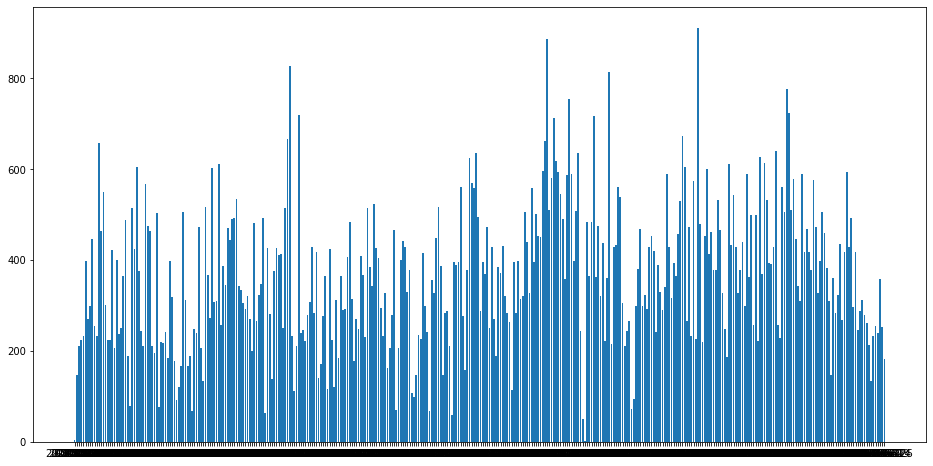

In [6]:
[dates, minPlayed] = np.transpose(np.array(*[res]))
minPlayed = list(map(float, minPlayed))
fig, ax = plt.subplots(figsize=(16, 8))
ax.bar(dates, minPlayed)

This doesn't give us so much information about my listening habits. Except that my record listening time in a day is

In [8]:
date = dates[minPlayed.index(max(minPlayed))]
print(str(max(minPlayed)/60) + " hours on the " + date + "!")

15.2 hours on the 2021-04-02!


Let's look at what happened there!

In [9]:
cmd = """ SELECT 
            endTime,
            msPlayed / 1000
          FROM 
            streaming_history
          WHERE
            date(endTime)='""" + date + "';"

cur = database.execute(cmd)
res = cur.fetchall()

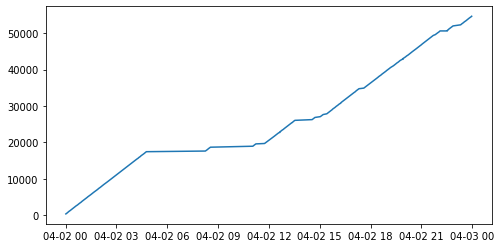

In [10]:
import datetime as dt

[time, secPlayed] = np.transpose(np.array(*[res]))
time = [dt.datetime.strptime(t, "%Y-%m-%d %H:%M") for t in time]
secPlayed = np.cumsum([int(sec) for sec in secPlayed])

fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(time, secPlayed)

So the diagonals show when I listened to music, and the horizontals when I didn't.

## The weekly listening history

Interesting would be to see how many hours of music I listen to on the different weekdays. The problem with sqlite is that we can't directly group by weekdays, so we have to find a workaround. We can format the date such that it gives us the last weekday, if it equals the date then it means we have the corresponding weekday.

In [11]:
weekDays = []
for i in range(7):
    cmd = """ SELECT 
                AVG(msPlayed) / 3600000
              FROM (
                SELECT 
                  date, 
                  SUM(msPlayed) AS msPlayed
                FROM (
                  SELECT 
                    date(endTime) AS date, 
                    msPlayed
                  FROM 
                    streaming_history
                  WHERE 
                    date=date(endTime, 'weekday """ + str(i) + """')
                  )
                GROUP BY date
              );       
          """

    cur = database.execute(cmd)
    res = cur.fetchall()
    weekDays.append(res[0][0])

<BarContainer object of 7 artists>

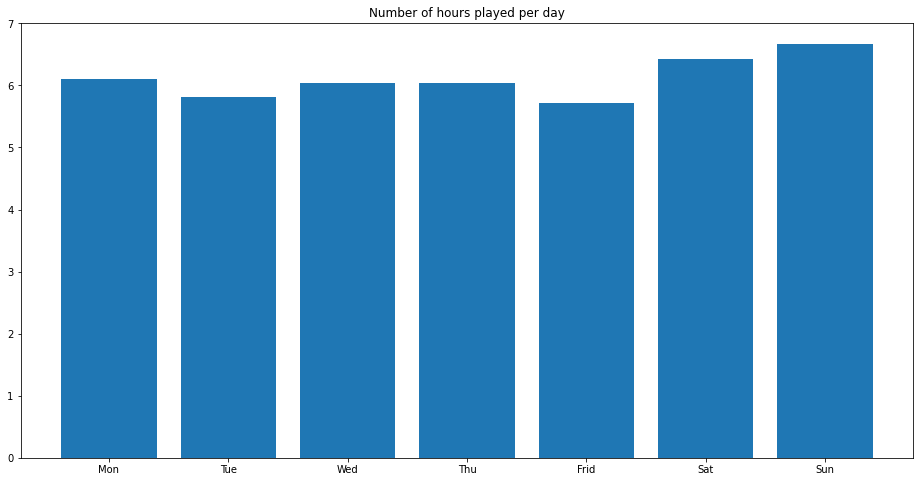

In [12]:
x = ["Mon", "Tue", "Wed", "Thu", "Frid", "Sat", "Sun"]
fig, ax = plt.subplots(figsize=(16, 8))
ax.title.set_text("Number of hours played per day")
ax.bar(x, weekDays)

Around 6 hours on average per day is quite a lot. Friday is the day I listen to least music and Sunday unsurprisingly the most. 

## The daily listening history

Another interesting statistics could be how much music I listen to at different hours of the day. Here we can use the strftime function which directly gives us the hour, so we can easly group and sum up the time.

In [13]:
cmd = """ 
        SELECT 
          strftime('%H', endTime),
          SUM(msPlayed) / 60000
        FROM
          streaming_history
        GROUP BY
          strftime('%H', endTime);
      """

cur = database.execute(cmd)
res = cur.fetchall()

<BarContainer object of 24 artists>

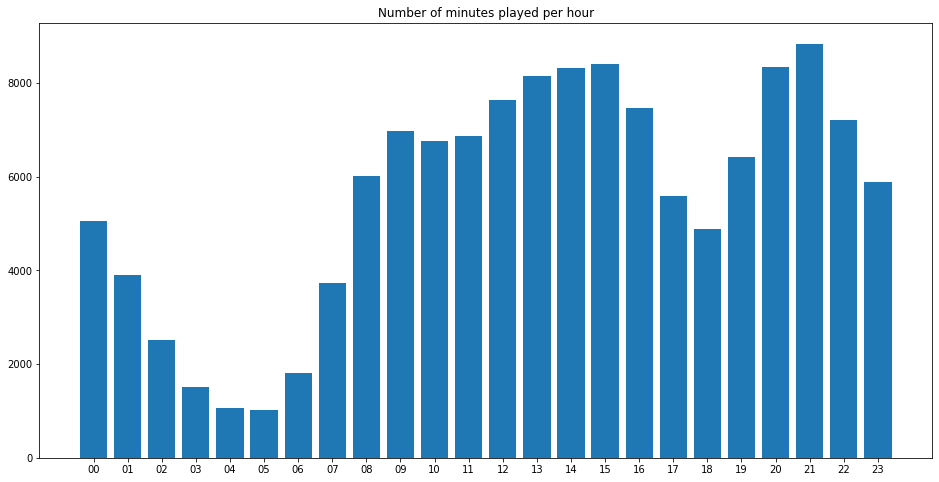

In [14]:
[hours, minutes] = np.array(*[res]).transpose()
fig, ax = plt.subplots(figsize=(16, 8))
ax.title.set_text("Number of minutes played per hour")
ax.bar(hours, list(map(float, minutes)))

Predictably at 5 in the morning is when I listen to the least music and at 9 in the evening the most.

# Analyzing listening per genre

## Loading the data

Unfortunatly, Spotify doesn't provide the genre of each song, but it provides multiple genres for each artist.

In [ ]:
cmd = """SELECT DISTINCT artistName FROM streaming_history;"""
cur = database.execute(cmd)
artist_list = cur.fetchall()

print("We have " + str(len(artist_list)) + " different artists")

We have 3627 different artists


The [Spotipy](https://spotipy.readthedocs.io/en/2.18.0/) library allows us to access all the music data provided by Spotify. The code to install the library:

In [ ]:
pip install spotipy --upgrade

We'll use the client credential flow, which has the advantage that we don't need the user authentification token. [The documentation](https://developer.spotify.com/documentation/general/guides/authorization-guide/#client-credentials-flow) about how you get the credentials needed. 

In [ ]:
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials

id = '627414d9842a40a9941c69152d1ef5d4'
secret = '9b1249549b214a9e9bd26f45cda8f44a'

auth_manager = SpotifyClientCredentials(client_id=id, client_secret=secret)
sp = spotipy.Spotify(auth_manager=auth_manager)

We can now get thee genres for each artist.

In [ ]:
values = []

for item in artist_list:
  artistName = item[0]
  results = sp.search(q=artistName, type='artist')
  
  try:
    results = results["artists"]["items"][0]
    genres = results["genres"]

    for genre in genres:
      value = (artistName, genre)
      values.append(value)
    
  except:
    print("not found: " + artistName)

We will again create a table which stores the genre and artist name, so we can relate it to the streaming history.

In [ ]:
#create
database.execute("""CREATE TABLE IF NOT EXISTS artist_genres(
                    artistName varchar(40),
                    genreName varchar(40),
                    id INTEGER PRIMARY KEY AUTOINCREMENT);""")
database.commit()

In [ ]:
for value in values:
    cmd = """INSERT INTO artist_genres VALUES(?, ?, null);"""
    database.execute(cmd, value)

database.commit()

In [15]:
cmd = """SELECT * FROM artist_genres LIMIT 5;"""
cur = database.execute(cmd)
res = cur.fetchall()
for r in res:
  print(r)

('Foo Fighters', 'alternative metal', 1)
('Foo Fighters', 'alternative rock', 2)
('Foo Fighters', 'modern rock', 3)
('Foo Fighters', 'permanent wave', 4)
('Foo Fighters', 'post-grunge', 5)


We see that an artist/group can have multiple genres. 

Let's try to get every modern rock from streaming history

In [16]:
cmd = """ SELECT 
                *
            FROM 
                streaming_history
            INNER JOIN 
                artist_genres 
            ON 
                streaming_history.artistName=artist_genres.artistName 
            WHERE 
                artist_genres.genreName='modern rock'
            LIMIT 5; """

cur = database.execute(cmd)
res = cur.fetchall()
for r in res:
  print(r)

('2020-06-24 07:45', 'Foo Fighters', 'These Days', 294417, 1, 'Foo Fighters', 'modern rock', 3)
('2020-06-28 15:20', 'Foo Fighters', 'Concrete and Gold', 0, 276, 'Foo Fighters', 'modern rock', 3)
('2020-07-01 13:25', 'Foo Fighters', 'These Days', 298266, 544, 'Foo Fighters', 'modern rock', 3)
('2020-07-02 13:55', 'Foo Fighters', 'But, Honestly', 275706, 649, 'Foo Fighters', 'modern rock', 3)
('2020-07-02 19:09', 'Foo Fighters', 'Times Like These', 3114, 708, 'Foo Fighters', 'modern rock', 3)


Now let's do the same thing as we did previously where we got the timed streamed per hours. But this time let's add a filter option for the genre, so we can the hourly stream for a specific genre.

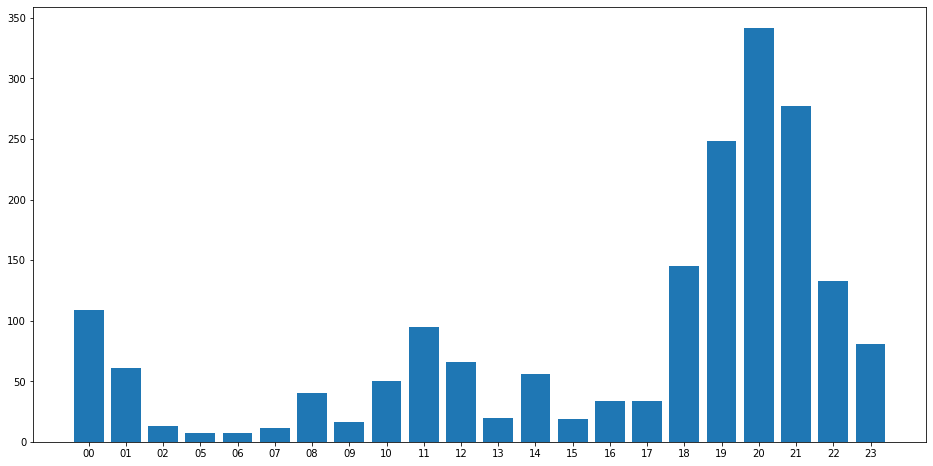

In [17]:
from datetime import datetime

def getHourlyGenreStreaming(genre):
    cmd = """ SELECT 
                  strftime('%H', endTime),
                  SUM(msPlayed) / 60000
              FROM 
                  streaming_history
              INNER JOIN 
                  artist_genres 
              ON 
                  streaming_history.artistName=artist_genres.artistName 
              WHERE 
                  artist_genres.genreName='""" + genre + """'
              GROUP BY
                  strftime('%H', endTime);"""
    cur = database.execute(cmd)
    res = cur.fetchall()
    return np.array(*[res]).transpose()

def plotHourlyStreamingHistory(time, minutes):
  fig, ax = plt.subplots(figsize=(16, 8))
  minutes = [int(m) for m in minutes]
  ax.bar(time, minutes)
  plt.show()

[time, minutes] = getHourlyGenreStreaming("metal")
plotHourlyStreamingHistory(time, minutes)

To be able to better compare what's going on, let's look at which are the most popular genres and then plot them against each other.

In [18]:
cmd = """ SELECT genreName, SUM(msPlayed)/(60*1000) FROM
          (
          SELECT artist_genres.genreName, streaming_history.trackName, streaming_history.msPlayed
          FROM streaming_history
          INNER JOIN artist_genres ON streaming_history.artistName=artist_genres.artistName
          )
          GROUP BY genreName
          ORDER BY SUM(msPlayed) DESC
          LIMIT 20;
          """

cur = database.execute(cmd)
res = cur.fetchall()
print("So my most popular streamed genres:")
for r in res:
  print(r[0] + " : " + str(r[1]) + " min")

So my most popular streamed genres:
rock : 31781 min
modern rock : 25201 min
pop : 24157 min
electropop : 13424 min
classic rock : 12918 min
indie poptimism : 11377 min
tropical house : 10589 min
album rock : 10283 min
pop dance : 9645 min
french indie pop : 9512 min
dance pop : 9303 min
pop rock : 9082 min
modern alternative rock : 8585 min
edm : 8465 min
art rock : 8272 min
permanent wave : 8173 min
alternative rock : 7821 min
mellow gold : 7347 min
soft rock : 6815 min
new french touch : 6784 min


Let's look at that on a pie plot.

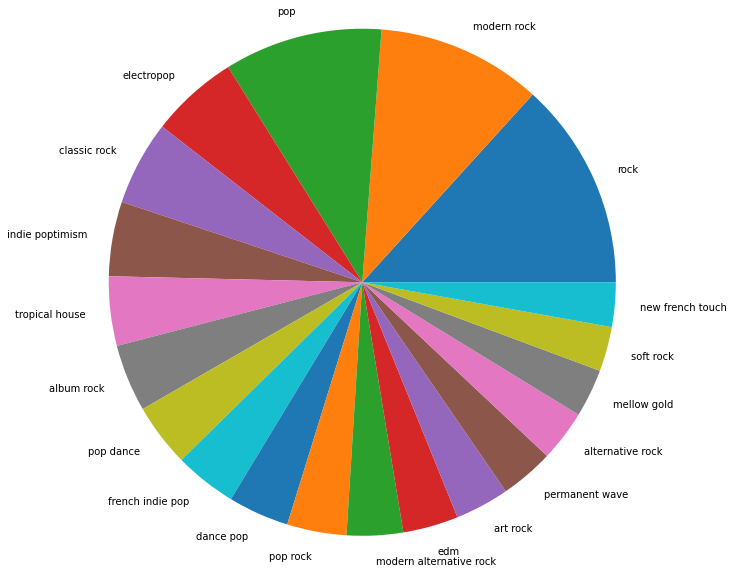

In [19]:
[labels, sizes] = np.array(*[res]).transpose()

fig, ax = plt.subplots(figsize=(10, 10))
ax.pie(sizes, labels=labels)
ax.axis('equal')

plt.show()

Let's simultaniously look at multiple genres.

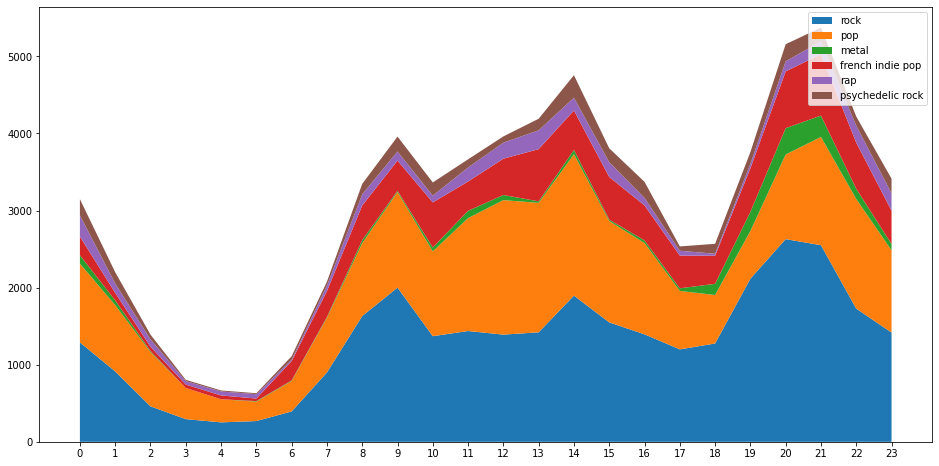

In [20]:
labels = [str(y) for y in range(24)]
genres = ["rock", "pop", "metal", "french indie pop", "rap", "psychedelic rock"]
fig, ax = plt.subplots(figsize=(16, 8))

hours = []

for genre in genres:
  [times, minutes] = getHourlyGenreStreaming(genre)
  hour = [0]*24
  for i in range(len(times)):
    hour[int(times[i])] = int(minutes[i])
  hours.append(hour)

ax.stackplot(labels, hours, labels=genres)
ax.legend()
plt.show()

So we can easly see at what time of the day, which genres I am listening to.